## Random Forest Classifier ##

### Import libraries ###

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from collections import Counter
from sklearn.model_selection import LearningCurveDisplay, learning_curve

### Load dataset and split to train and test ###

In [2]:
# Load the dataset
df = pd.read_csv('../data/tfidf_output_cleaned.csv')
df_copy = df.copy()

# Split the data into features (X) and labels (y)
X = df_copy['imp_feature']
y = df_copy['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Convert a pandas Series to a DataFrame
X_train_series = pd.Series(X_train)
X_train_df = X_train_series.to_frame()
# num_spam1 = y_train[y_train_resampled == 1].shape[0]
# num_ham1 = y_train[y_train_resampled == 0].shape[0]

# Tạo RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Áp dụng oversampling cho dữ liệu huấn luyện
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_df, y_train)
X_train_resampled = X_train_resampled.squeeze()
#X_train_resampled,  y_train_resampled
print(X_train)
num_spam = y_train_resampled[y_train_resampled == 1].shape[0]
num_ham = y_train_resampled[y_train_resampled == 0].shape[0]

2167                                check head drop stuff
3862    hiya u like hlday pic look horribl took mo how...
1424                      sent email address incomm right
326     call germani 1 penc per minut call fix line vi...
604                                 call said choos futur
                              ...                        
4426    weekli tone readi download week new tone inclu...
466                 ok gon na head usf like fifteen minut
3092    moon come color dream star make music sm give ...
3772    u gd lor go shop got stuff u wan 2 watch infer...
860     remind download content alreadi paid goto http...
Name: imp_feature, Length: 3870, dtype: object


### Draw pie chart ###

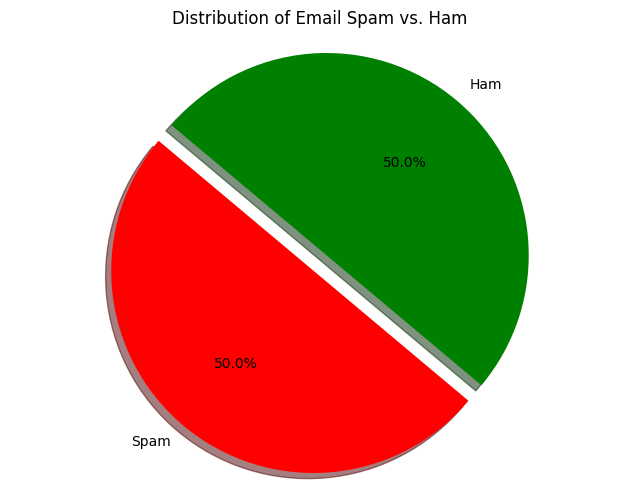

In [3]:
labels = ['Spam', 'Ham']
sizes = [num_spam, num_ham]
colors = ['red', 'green']
explode = (0.1, 0)  # Tách phần Spam ra một chút

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.title('Distribution of Email Spam vs. Ham')
plt.show()

### Use TF_IDF to convert data ###

In [4]:
# Define TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit and transform TF-IDF vectorizer on resampled training data
X_train_tfidf = tfidf.fit_transform(X_train_resampled)

### RF grid search ###

In [5]:
# Define RandomForestClassifier model
RF_clf = RandomForestClassifier()

In [6]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_leaf_nodes': [None, 1000, 10000]  
}

# Create GridSearchCV object
grid_search = GridSearchCV(RF_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train_resampled)

# Output the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

{'max_leaf_nodes': None, 'n_estimators': 50}
0.9994068581408803


### Check spam ###

In [8]:
# Make predictions on training and test data
X_test_tfidf = tfidf.transform(X_test)
y_pred_train = grid_search.predict(X_train_tfidf)
y_pred_test = grid_search.predict(X_test_tfidf)

print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))

Train Accuracy:  1.0
Test Accuracy:  0.9713178294573643


### Train with the best param ###

In [17]:
#X_train_tfidf = tfidf.fit_transform(X_train)
X_train_tfidf = tfidf.fit_transform(X_train_resampled)

RF_clf = RandomForestClassifier(max_leaf_nodes=1000, n_estimators=200)
RF_clf.fit(X_train_tfidf, y_train_resampled)

# Make predictions on the test data
X_test_tfidf = tfidf.transform(X_test)  # Transform test data using the same TF-IDF vectorizer
RF_predictions = RF_clf.predict(X_test_tfidf)

In [19]:
print(classification_report(y_test, RF_predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1135
           1       0.97      0.81      0.88       155

    accuracy                           0.97      1290
   macro avg       0.97      0.90      0.93      1290
weighted avg       0.97      0.97      0.97      1290



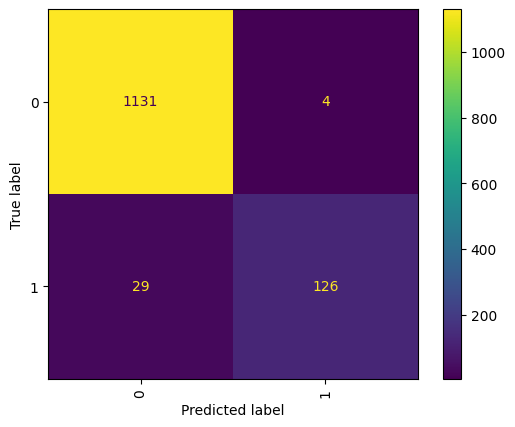

In [20]:
RF_cm = confusion_matrix(y_test, RF_predictions, labels=RF_clf.classes_)
RF_disp = ConfusionMatrixDisplay(confusion_matrix=RF_cm, display_labels=RF_clf.classes_)
RF_disp.plot(xticks_rotation = "vertical")
plt.show()

### Get predict and evaluate the model ###

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
x_test = tfidf.transform(X_test)
x_pred = grid_search.predict(x_test)

def perform(y_pred):
    print("Precision : ", precision_score(y_test, y_pred))
    print("Recall : ", recall_score(y_test, y_pred))
    print("Accuracy Score : ", accuracy_score(y_test, y_pred))
    print("F1 Score : ", f1_score(y_test, y_pred))

perform(x_pred)

Precision :  0.946969696969697
Recall :  0.8064516129032258
Accuracy Score :  0.9713178294573643
F1 Score :  0.8710801393728222
